In [ ]:
!pip install kornia
!pip install torch torchvision torchaudio

In [ ]:
import matplotlib.pylab as plt

import torch
from torchvision import transforms

import skimage
from skimage import data
from skimage.exposure import match_histograms

from kornia.contrib import histogram_matching

In [ ]:
reference = data.coffee()
image = data.chelsea()

# Histogram Matching with Skimage

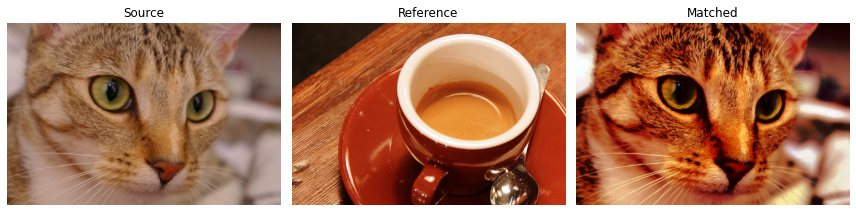

In [ ]:
# Histogram matching with skimage
matched = match_histograms(image, reference, multichannel=True)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 5),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

# Histogram Matching with the current Kornia version

In [ ]:
# convert numpy images to Torch tensor
torch_reference = transforms.ToTensor()(reference)
torch_image = transforms.ToTensor()(image)

torch_matched_kornia_current = histogram_matching(torch_image, torch_reference)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


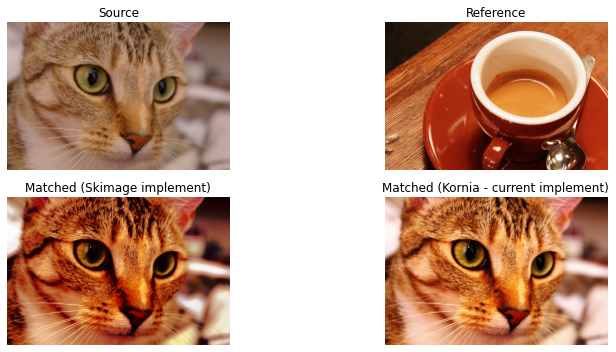

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 5),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3, ax4):
    aa.set_axis_off()


# Show skimage results
ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')

# Show torch (Kornia) results
ax3.imshow(matched)
ax3.set_title('Matched (Skimage implement)')

ax4.imshow(torch_matched_kornia_current.permute(1, 2, 0))
ax4.set_title('Matched (Kornia - current implement)')

plt.tight_layout()
plt.show()

# Fix the implementation of the histogram matching function

In [ ]:
def histogram_matching_update(source: torch.Tensor, template: torch.Tensor) -> torch.Tensor:
    """Adjust the pixel values of an image to match its histogram towards a target image.
    Args:
        source: Image to transform.
        template: Template image. It can have different dimensions to source.
    Returns:
        The transformed output image as the same shape as the source image.
    Note:
        This function does not matches histograms element-wisely if input a batched tensor.
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and counts.
    _, bin_idx, s_counts = torch.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = torch.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)

    s_quantiles = torch.cumsum(s_counts, dim=0, dtype=source.dtype)
    s_quantiles = s_quantiles / s_quantiles[-1]
    t_quantiles = torch.cumsum(t_counts, dim=0, dtype=source.dtype)
    t_quantiles = t_quantiles / t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)


def interp(x: torch.Tensor, xp: torch.Tensor, fp: torch.Tensor) -> torch.Tensor:
    """One-dimensional linear interpolation for monotonically increasing sample
    points.

    Returns the one-dimensional piecewise linear interpolant to a function with
    given discrete data points :math:`(xp, fp)`, evaluated at :math:`x`.
    
    This is confirmed to be a correct implementation. 
    See https://github.com/pytorch/pytorch/issues/1552#issuecomment-979998307

    Args:
        x: the :math:`x`-coordinates at which to evaluate the interpolated
            values.
        xp: the :math:`x`-coordinates of the data points, must be increasing.
        fp: the :math:`y`-coordinates of the data points, same length as `xp`.

    Returns:
        the interpolated values, same size as `x`.
    """
    i = torch.clip(torch.searchsorted(xp, x, right=True), 1, len(xp) - 1)

    return (fp[i - 1] *  (xp[i] - x) + fp[i] * (x - xp[i - 1])) / (xp[i] - xp[i - 1])

In [ ]:
# get the matched tensor from new function
torch_matched_kornia_fixed = histogram_matching_update(torch_image, torch_reference)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


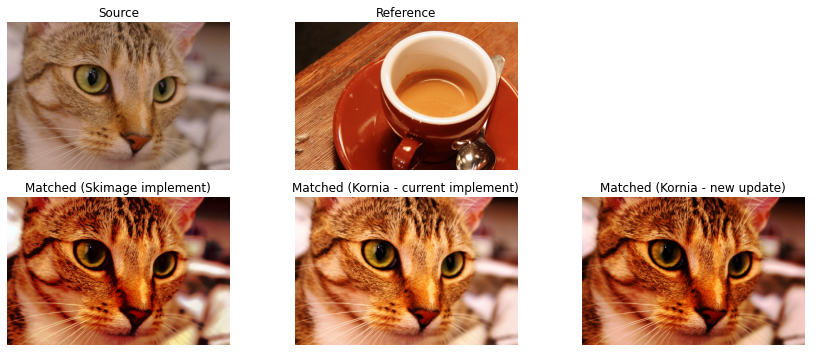

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 5),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3, ax4, ax5, ax6):
    aa.set_axis_off()


# Show skimage results
ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')


# Show torch (Kornia) results
ax4.imshow(matched)
ax4.set_title('Matched (Skimage implement)')

ax5.imshow(torch_matched_kornia_current.permute(1, 2, 0))
ax5.set_title('Matched (Kornia - current implement)')

ax6.imshow(torch_matched_kornia_fixed.permute(1, 2, 0))
ax6.set_title('Matched (Kornia - new update)')

plt.tight_layout()
plt.show()